# Collecting Pipeline Data/Statistics

The purpose of this notebook is to collect statistics on the postfiltering values of stars which are known to be dim hpms and large datasets from DES. These statistics will help inform how much we should constrain and filter in the pipeline (parameter tweaking).

In [2]:
# Dask puts out more advisory logging that we care for.
# It takes some doing to quiet all of it, but this recipe works.
import dask
import logging
import dask_jobqueue
from dask.dataframe.utils import make_meta
from dask.distributed import Client

dask.config.set({"logging.distributed": "critical"})

# This also has to be done, for the above to be effective
logger = logging.getLogger("distributed")
logger.setLevel(logging.CRITICAL)

import warnings

# Finally, suppress the specific warning about Dask dashboard port usage
warnings.filterwarnings("ignore", message="Port 8787 is already in use.")

from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
import time

from hats import read_hats

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [3]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
mag = 19
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,mag=mag)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 2
max_obj_deviation = 0.2
des_id_col = 'COADD_OBJECT_ID_1'
mag_cols = [f'WAVG_MAG_PSF_{band}' for band in ['I']]
min_neighbors = 4
max_neighbor_dist = 24
xmatch_max_neighbors = 100
print("Defined globals.")

Defined globals.


## Pipeline stats on 2-Degree conesearch near HPMS

The current implementation of this pipeline is too computationally expensive to be ran on a two degree conesearch, thus we collect data from a subset of the two degree consearch to get data to extrapolate from.

In [5]:
BENCHMARK_CATALOG_DIR = Path("../../../catalogs/benchmark_catalogs")
CATALOG_NAME = "2.306965202564744e+18"
CATALOG_MC_NAME = "2306965202564744e18_25_arcsec_mc"
CATALOG_DIR = BENCHMARK_CATALOG_DIR / CATALOG_NAME
CATALOG_MC_DIR = BENCHMARK_CATALOG_DIR / CATALOG_MC_NAME

two_deg_catalog = lsdb.read_hats(CATALOG_DIR, margin_cache=CATALOG_MC_DIR)
two_deg_catalog.map_partitions(len).compute()

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/dask/dataframe/dask_expr/_expr.py:4078: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:534: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


0     12225
0    356855
0     49602
0    373822
0    434557
0      6512
0    272653
0       489
0     13400
0     47374
dtype: int64

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Angular density of catalog 2.306965202564744e+18'}>)

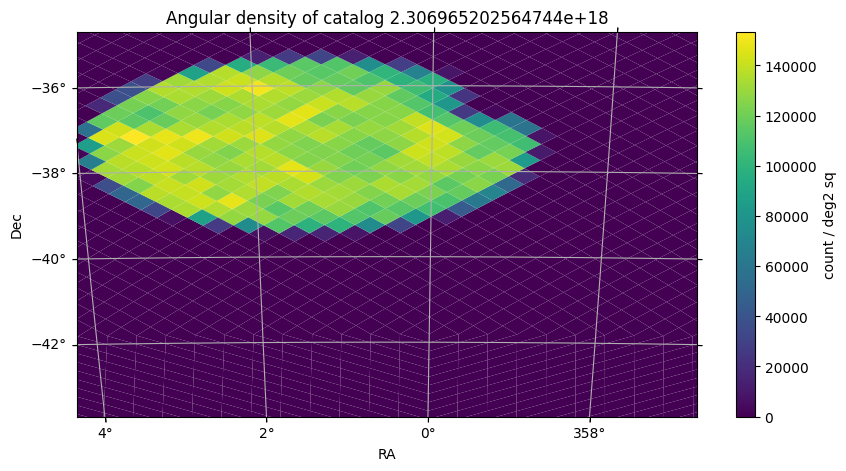

In [6]:
from hats.inspection import plot_density
import astropy.units as u
from astropy.coordinates import SkyCoord

fov = (5 * u.deg, 10 * u.deg)
center = SkyCoord(0.512774 * u.deg, -39.245494 * u.deg)
plot_density(two_deg_catalog.hc_structure, order=8, edgecolors='None', fov=fov, center=center)

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - 2.306965202564744e+18'}>)

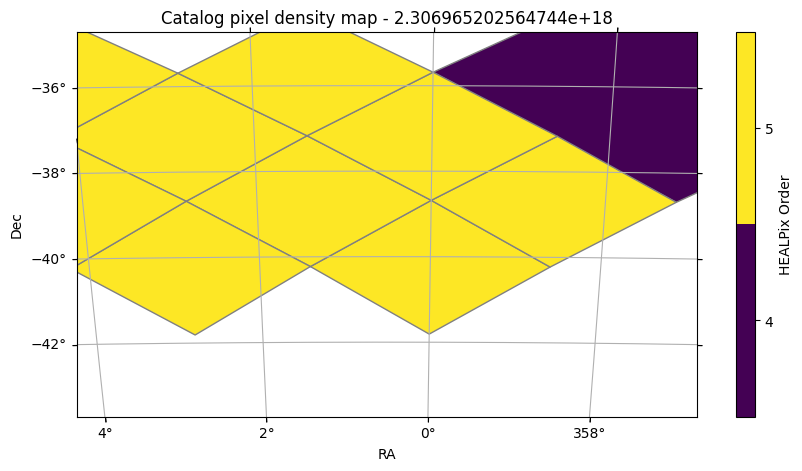

In [7]:
two_deg_catalog.plot_pixels(fov=fov, center=center,edgecolors='grey')

### Unfiltered 1/3 Degree Consearch Stats

In [8]:
two_deg_catalog_computed = two_deg_catalog.compute()
two_deg_catalog_computed

,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,FLAGS_G,FLAGS_R,FLAGS_I,FLAGS_Z,FLAGS_Y,RA,DEC,COADD_OBJECT_ID,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,NEPOCHS_G,NEPOCHS_R,NEPOCHS_I,NEPOCHS_Z,NEPOCHS_Y
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153164897846752218,0.374912,0.657164,0.488149,0.633625,0.359696,0,0,0,0,0,0.512774,-39.245494,1035453846,0.007072,0.012759,-0.004265,-0.012841,-0.019321,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0
1153164899469843282,0.517612,0.505923,0.489793,0.143575,0.357794,0,0,0,0,0,0.510428,-39.244757,1035453778,0.018517,0.001991,0.003956,-0.007459,-0.030485,24.296503,-99.0,-99.0,-99.0,-99.0,0.310851,-99.0,-99.0,-99.0,-99.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499210522172832374,0.717833,0.832164,0.833571,0.001383,0.505624,0,0,0,0,0,3.892279,-37.523257,1051532822,0.002676,0.00037,0.008703,0.010534,-0.032781,23.902689,23.898844,23.62042,-99.0,-99.0,0.204214,0.239056,0.349378,-99.0,-99.0,2,1,1,0,0
2499210522274011968,0.473098,0.69807,0.28789,0.002372,0.469326,0,0,0,0,0,3.892586,-37.522114,1051532692,0.023274,0.006568,0.015259,0.002986,-0.030276,-99.0,-99.0,23.198511,-99.0,-99.0,-99.0,-99.0,0.376349,-99.0,-99.0,0,0,1,0,0


In [9]:
missed_val = -99.0

with Client():
    missed_detections = two_deg_catalog.map_partitions(hpms.num_missed_detections, 
                                             ['WAVG_MAG_PSF_G', 'WAVG_MAG_PSF_R', 
                                              'WAVG_MAG_PSF_I', 'WAVG_MAG_PSF_Z', 
                                              'WAVG_MAG_PSF_Y'], missed_val).compute()

missed_totals = [
    (two_deg_catalog_computed[f'WAVG_MAG_PSF_{band}'] == missed_val).to_numpy().sum() for band in bandList
]

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:534: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


G band: 0.5182996499496966% missed detection
R band: 0.42703521364424246% missed detection
I band: 0.49832247626618115% missed detection
Z band: 0.6213702297113409% missed detection
Y band: 0.8340154221177948% missed detection


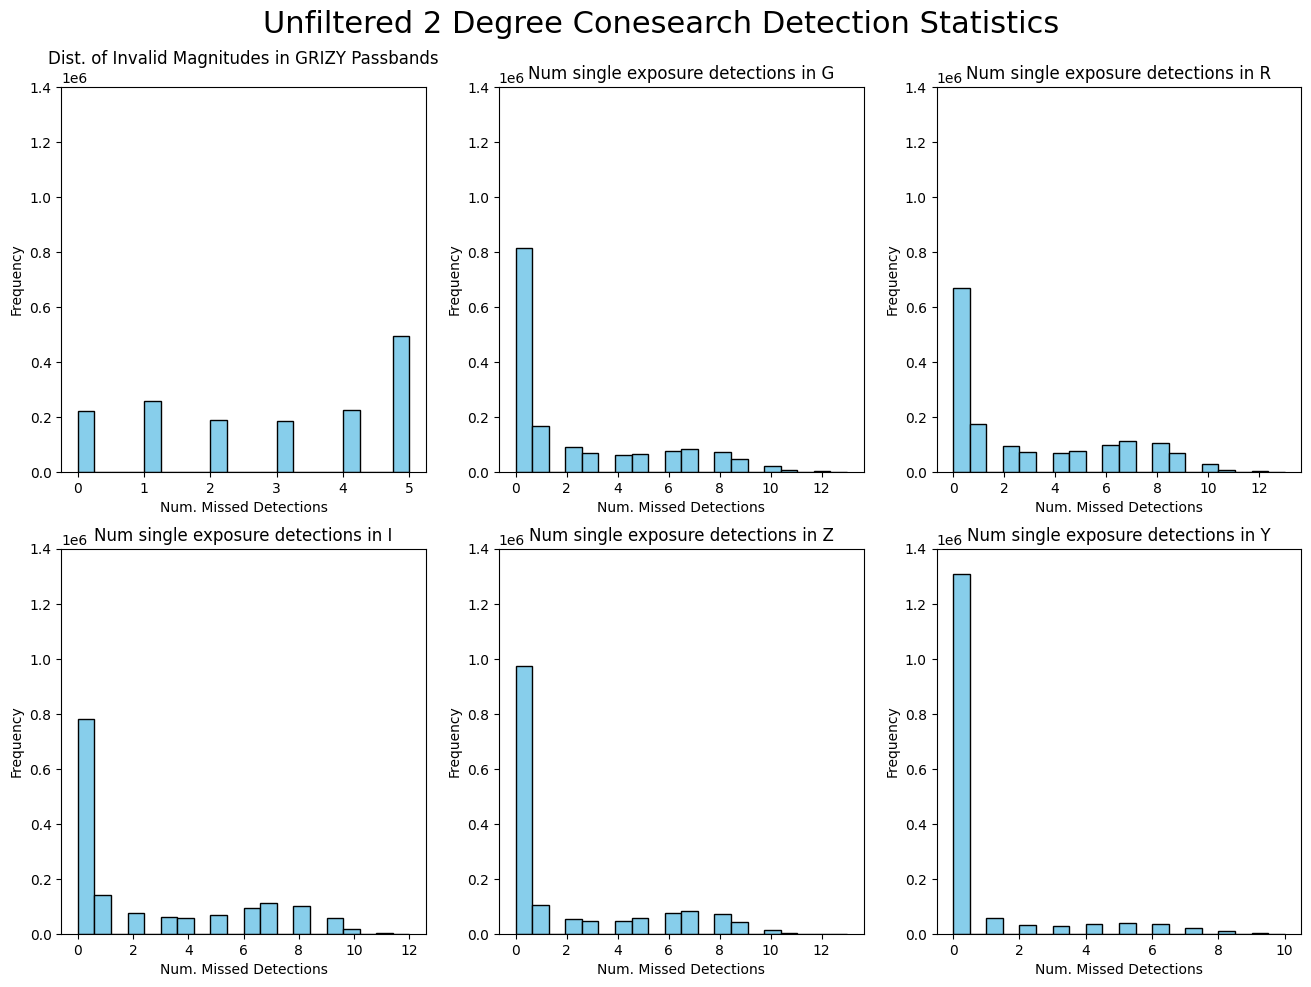

In [10]:
warnings.filterwarnings("ignore", category=UserWarning, module="dask.dataframe.dask_expr._collection")

for band, missed in zip(bandList, missed_totals):
    print(f"{band} band: {missed/len(two_deg_catalog_computed)}% missed detection")
    
fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Unfiltered 2 Degree Conesearch Detection Statistics', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G', 'NEPOCHS_R', 'NEPOCHS_I', 'NEPOCHS_Z', 'NEPOCHS_Y'] 
columns = [missed_detections] + [two_deg_catalog_computed[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in bandList]

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')
    ax.set_ylim(top=1400000)

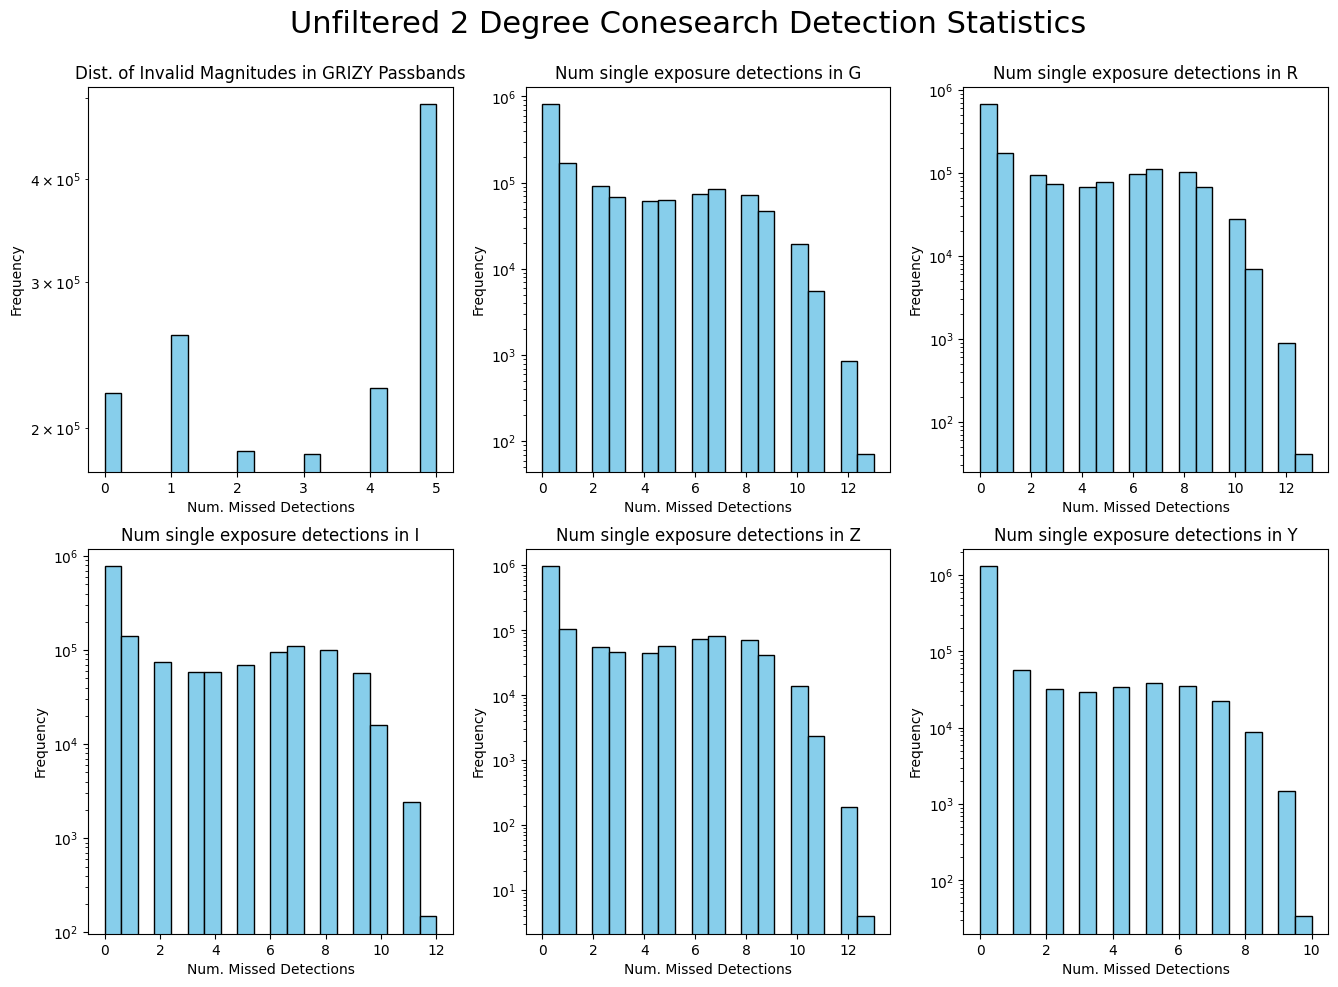

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Unfiltered 2 Degree Conesearch Detection Statistics', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G', 'NEPOCHS_R', 'NEPOCHS_I', 'NEPOCHS_Z', 'NEPOCHS_Y'] 
columns = [missed_detections] + [two_deg_catalog_computed[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in bandList]

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')

In [12]:
import importlib
importlib.reload(hpms)

<module 'hpms_pipeline' from '/ocean/projects/phy210048p/jpassos/astrophysics/Jupyter Notebooks/kth_star_pipeline/hpms_pipeline.py'>

In [13]:
print(two_deg_catalog.npartitions)

10


In [14]:
from dask.distributed import performance_report

RESULTS_DIR = BENCHMARK_CATALOG_DIR / 'two_deg_cs_results'
print(f"Length of catalog: {len(two_deg_catalog)}")

start_wall = time.time()
print('Start time:',start_wall)
with Client(threads_per_worker=1, memory_limit='25GB', n_workers=10), performance_report(filename='two_deg_run_2.html'):
    hpms.execute_pipeline(two_deg_catalog, query_string, xmatch_max_neighbors,
                          max_neighbor_dist, min_neighbors, k,
                          max_obj_deviation, des_id_col, mag_cols).to_hats(catalog_name='two_deg_cs_results', 
                                                                           base_catalog_path=RESULTS_DIR)

wall_time = time.time() - start_wall
print("Wall time: ", wall_time)

Length of catalog: 1567489
Start time: 1751550229.0720072
Wall time:  5346.6102159023285


### Filtered 1/3 Degree Consearch Stats

In [116]:
two_deg_results = lsdb.read_hats(RESULTS_DIR)
computed_results = two_deg_results.compute()
filtered_size = len(computed_results)
print(f"Length of filtered subset: {filtered_size}")
computed_results

Length of filtered subset: 172056


,COADD_OBJECT_ID_1,CLASS_STAR_G_2,CLASS_STAR_R_2,CLASS_STAR_I_2,CLASS_STAR_Z_2,CLASS_STAR_Y_2,FLAGS_G_2,FLAGS_R_2,FLAGS_I_2,FLAGS_Z_2,FLAGS_Y_2,RA_2,DEC_2,COADD_OBJECT_ID_2,SPREAD_MODEL_G_2,SPREAD_MODEL_R_2,SPREAD_MODEL_I_2,SPREAD_MODEL_Z_2,SPREAD_MODEL_Y_2,WAVG_MAG_PSF_G_2,WAVG_MAG_PSF_R_2,WAVG_MAG_PSF_I_2,WAVG_MAG_PSF_Z_2,WAVG_MAG_PSF_Y_2,WAVG_MAGERR_PSF_G_2,WAVG_MAGERR_PSF_R_2,WAVG_MAGERR_PSF_I_2,WAVG_MAGERR_PSF_Z_2,WAVG_MAGERR_PSF_Y_2,NEPOCHS_G_2,NEPOCHS_R_2,NEPOCHS_I_2,NEPOCHS_Z_2,NEPOCHS_Y_2,kth_min_deviation,max_obj_distance,max_mag_diff,__index_level_0__
0,1035453138,0.019152,0.02412,0.009233,0.000468,0.003988,0,0,0,0,0,0.496413,-39.243022,1035452338,-0.052924,-0.03122,-0.014285,-0.014959,-0.081807,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,0.149451,40.533407,2.327496,10
1,1035452563,0.330949,0.018806,0.073977,0.002738,0.050932,0,0,0,0,0,0.449055,-39.231687,1035452088,-0.008991,-0.002878,-0.004254,-0.024502,-0.08301,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,0.158809,36.415721,inf,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5736,1051533308,0.007011,0.016503,0.028101,0.000178,0.000472,0,0,0,0,0,3.883165,-37.534372,1051532702,-0.019002,-0.014787,-0.02129,-0.027938,-0.061235,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,0.153257,24.287375,inf,46981
5737,1051532755,0.007011,0.016503,0.028101,0.000178,0.000472,0,0,0,0,0,3.880146,-37.527893,1051532120,-0.044845,-0.091,-0.02129,-0.027938,-0.061235,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,0.193151,31.524766,inf,46986


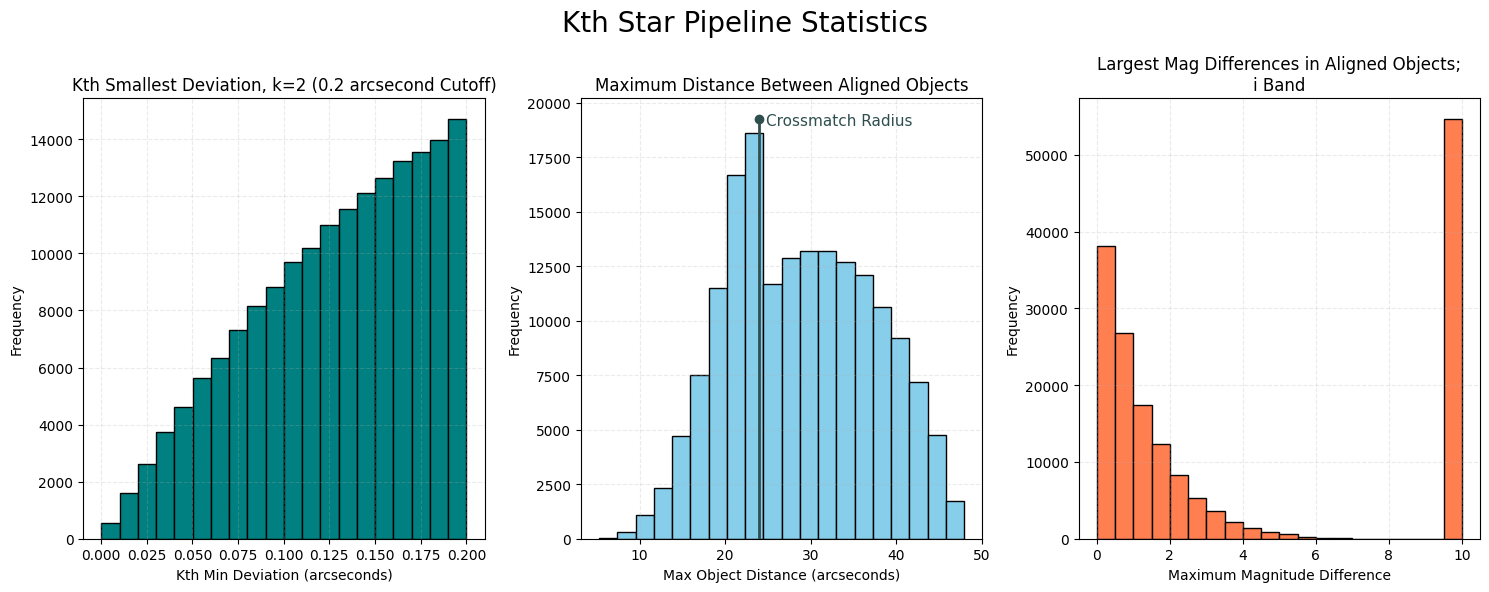

In [117]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Kth Star Pipeline Statistics', size = 20)

x_axis = ['Kth Min Deviation (arcseconds)', 'Max Object Distance (arcseconds)', 'Maximum Magnitude Difference']
columns = ['kth_min_deviation', 'max_obj_distance', 'max_mag_diff']
titles = [f'Kth Smallest Deviation, k={k} (0.2 arcsecond Cutoff)', f'Maximum Distance Between Aligned Objects', f'Largest Mag Differences in Aligned Objects;\ni Band']
colors = ['teal', 'skyblue', 'coral']

for ax, col, x_label, name, color in zip(axes, columns, x_axis, titles, colors):
    
    computed_results[col] = computed_results[col].replace([np.inf, -np.inf], 10)
    
    ax.hist(computed_results[col], bins=20, color=color, edgecolor='black')
    if (x_label == 'Max Object Distance (arcseconds)'):
        xmatch_cutoff = 24
        ax.axvline(x=xmatch_cutoff,ymin=0,ymax=.96, color='darkslategrey',lw=2)
        ax.text(xmatch_cutoff + 0.8, 19550, 'Crossmatch Radius', va='top', ha='left', color='darkslategrey', size=11)
        ax.plot(xmatch_cutoff,19250,marker='o', color='darkslategrey')
        

    ax.grid(True, linestyle='--', alpha=0.25)
    ax.set_title(name)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x149259b39310>>
Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

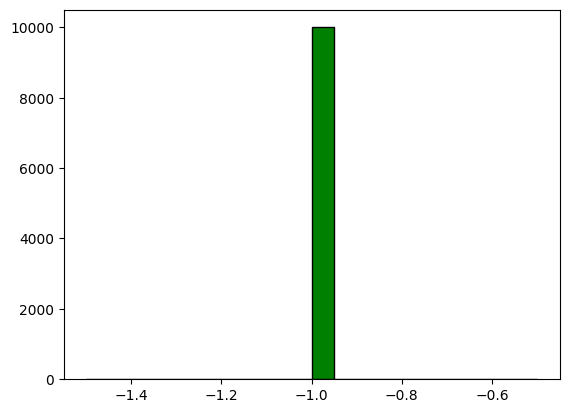

In [24]:
sampled_diffs = hpms.sample_mag_diffs(two_deg_results, 'WAVG_MAG_PSF_I_2', 10000)
plt.hist(sampled_diffs, bins=20, color='green', edgecolor='black')
plt.set_title('i Band Magnitude Deltas Randomly Sampled in DES')
plt.xlabel('Magnitude Delta')
plt.ylabel('Freqeuncy')

In [59]:
with Client(threads_per_worker=1, memory_limit='25GB', n_workers=10):
    missed_detections_filtered = two_deg_results.map_partitions(hpms.num_missed_detections, 
                                             ['WAVG_MAG_PSF_G_2', 'WAVG_MAG_PSF_R_2', 
                                              'WAVG_MAG_PSF_I_2', 'WAVG_MAG_PSF_Z_2', 
                                              'WAVG_MAG_PSF_Y_2'], missed_val).compute()

missed_totals = [
    (computed_results[f'WAVG_MAG_PSF_{band}_2'] == missed_val).to_numpy().sum() for band in bandList
]

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:534: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


In [127]:
print(len(computed_results))

172056


In [60]:
missed_detections_filtered

0       5
1       5
       ..
5736    5
5737    5
Name: n_missed_detections, Length: 172056, dtype: int64

G band: 0.9999767517552425% missed detection
R band: 0.9998140140419398% missed detection
I band: 0.9999825638164319% missed detection
Z band: 1.0% missed detection
Y band: 1.0% missed detection
172056
172056


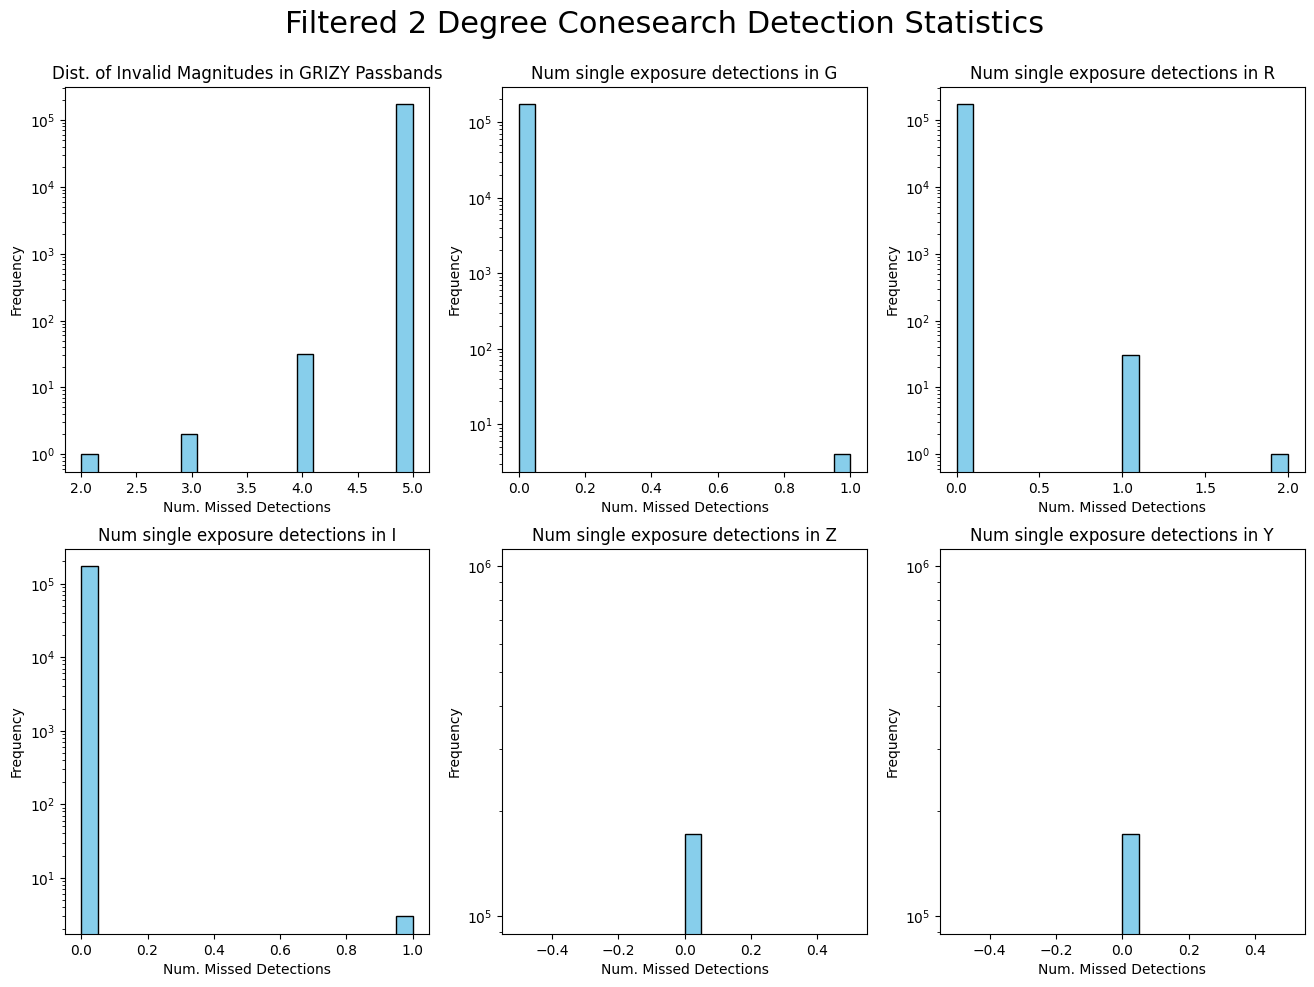

In [128]:
warnings.filterwarnings("ignore", category=UserWarning, module="dask.dataframe.dask_expr._collection")

for band, missed in zip(bandList, missed_totals):
    print(f"{band} band: {missed/len(computed_results)}% missed detection")

fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Filtered 2 Degree Conesearch Detection Statistics', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G_2', 'NEPOCHS_R_2', 'NEPOCHS_I_2', 'NEPOCHS_Z_2', 'NEPOCHS_Y_2'] 
columns = [missed_detections_filtered] + [computed_results[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in bandList]
print((computed_results['NEPOCHS_Y_2'] == 0).sum())
print((computed_results['NEPOCHS_Z_2'] == 0).sum())

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')


##  Stats on Found HPMS

In [12]:
des_dim_hpms = pd.read_csv('des_dim_hpms.csv')
n_missed_detections=[]

for idx, row in des_dim_hpms.iterrows():
    passbands = row[[f'WAVG_MAG_PSF_{band}' for band in bandList]]
    n_missed_detections.append((passbands == -99.0).values.sum())
    
des_dim_hpms['n_missed_detections']=n_missed_detections
des_dim_hpms

,_healpix_29,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,FLAGS_G,FLAGS_R,FLAGS_I,FLAGS_Z,...,NEPOCHS_Y,source_id,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,n_missed_detections
0,2365588896711673656,0.679783,0.673899,0.686970,0.415550,0.570589,3,3,3,3,...,0,4731177819694416000,57.791234,-56.456615,272.491124,-1043.112326,19.997510,20.687986,19.061255,5
1,2365588907847830054,0.028272,0.034199,0.029082,0.028588,0.027390,3,3,3,3,...,2,4731177819694416000,57.791234,-56.456615,272.491124,-1043.112326,19.997510,20.687986,19.061255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,3206298016903817602,0.768001,0.133280,0.076799,0.102573,0.260082,1,1,1,1,...,0,6412596012146801152,331.076453,-56.793812,3981.976663,-2466.831815,18.030664,21.142073,16.060108,3
55,3206298056050087471,0.568923,0.515469,0.201747,0.059395,0.380853,0,0,0,0,...,0,6412596012146801152,331.076453,-56.793812,3981.976663,-2466.831815,18.030664,21.142073,16.060108,4


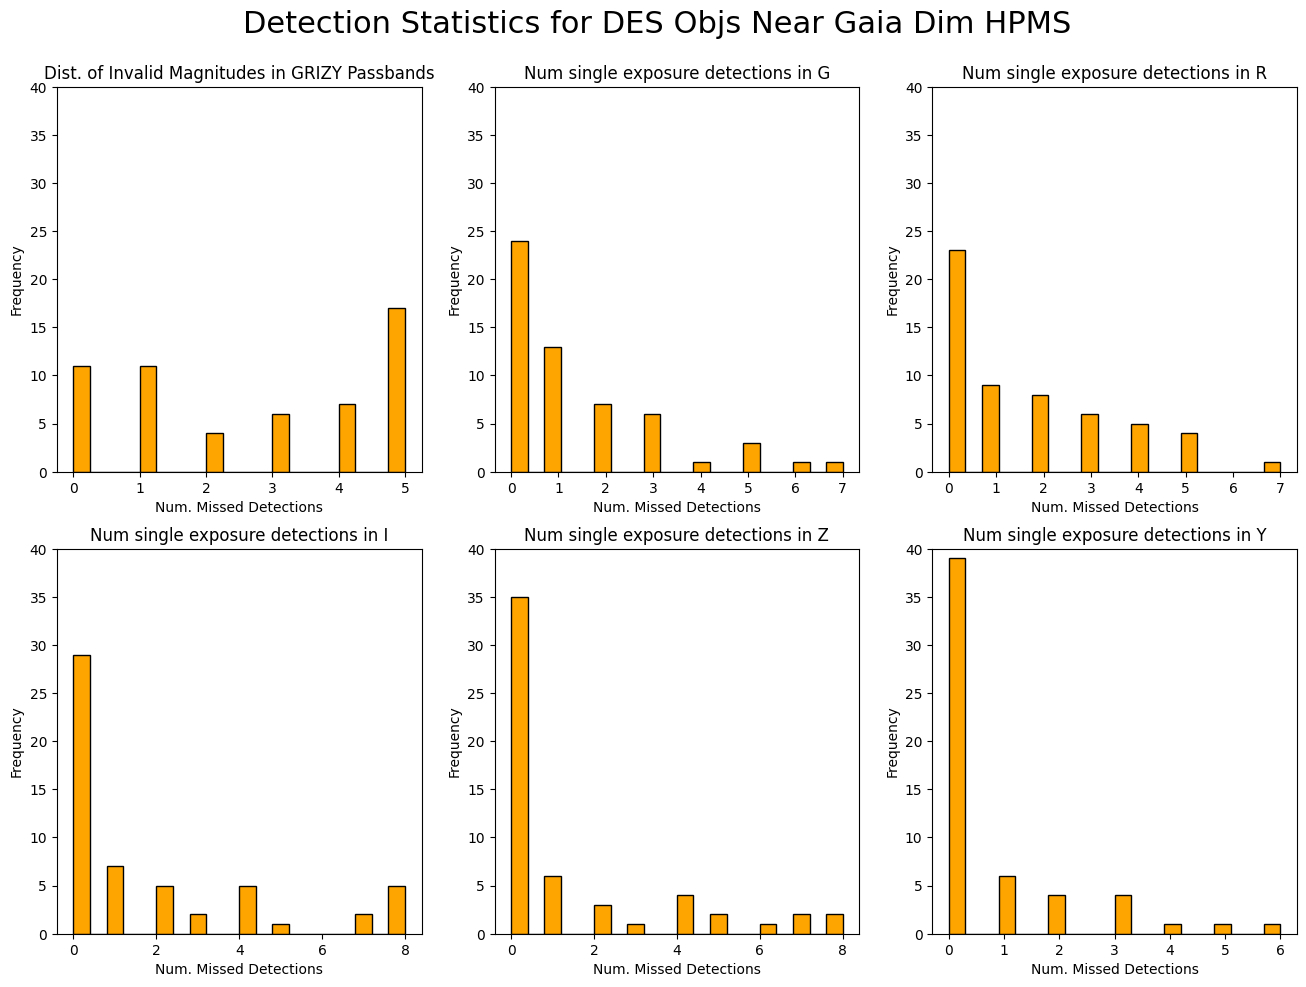

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Detection Statistics for DES Objs Near Gaia Dim HPMS', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G', 'NEPOCHS_R', 'NEPOCHS_I', 'NEPOCHS_Z', 'NEPOCHS_Y'] 
columns = [n_missed_detections] + [des_dim_hpms[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in bandList]

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='orange', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')
    ax.set_ylim(top=40)

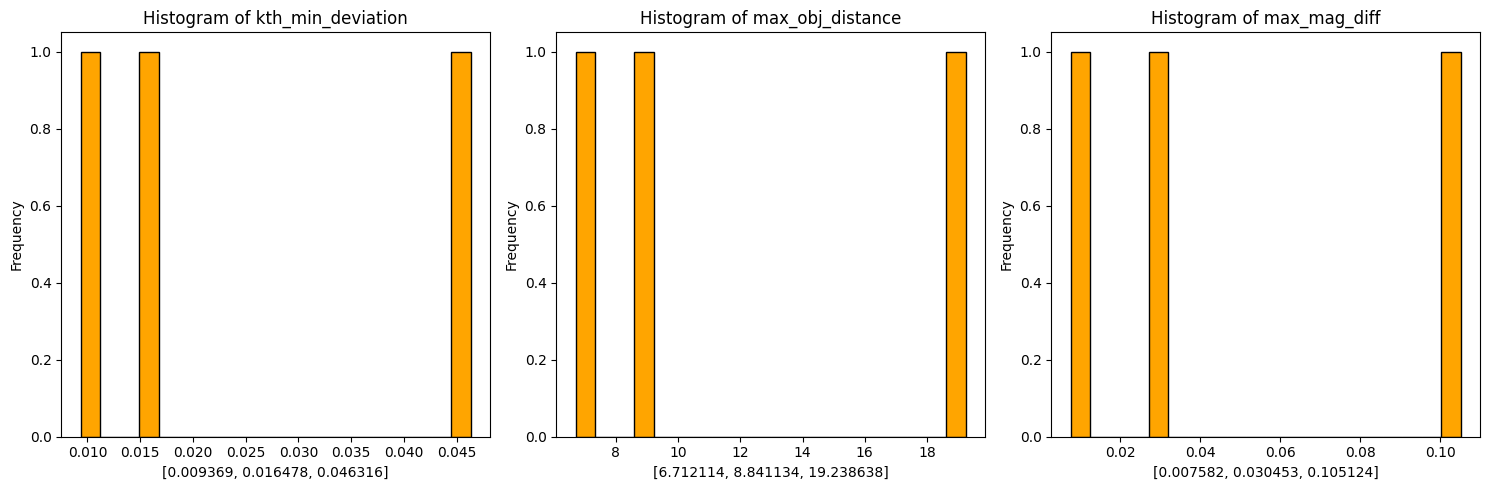

In [16]:
#These were manually obtained from runs in test_execute_pipeline.ipynb

kth_min_deviation = [0.009369,0.016478,0.0463160]
max_obj_distance = [6.712114,8.841134,19.238638]
max_mag_diff = [.007582, 0.030453, 0.105124]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

columns = [kth_min_deviation, max_obj_distance, max_mag_diff]
names = ['kth_min_deviation', 'max_obj_distance', 'max_mag_diff']

for ax, col, name in zip(axes, columns, names):
    ax.hist(col, bins=20, color='orange', edgecolor='black')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()